+ Requirements:
    1. The "tools_camera.py" file.
    2. Images of the "imgs/calibration" and "imgs/calibration_wide" directories for the example calibration with OpenCV functionality.
    3. The estimated time to carry out this activity is approximately half an hour.
<br><br>
+ Objectives of the notebook:
    1. Calibrate the model of a camera.
<br><br>
+ Summary of activities:
    1. Code implemented in Python with Numpy will be analyzed.
    2. Code implemented with OpenCV functionality will be analyzed.

# Camera calibration

The calibration process consists of estimating the projection matrix $^{d}\mathbf{M}_w$ of a camera. We know that this matrix allows us to calculate the undistorted image pixels $\mathbf{p}_{d}$ from the world points $\mathbf{p}_w$.

$$ \mathbf{p}_{d} = \begin{bmatrix} s \, u \\ s \, v \\ s \end{bmatrix} ;\:\:\:\: \mathbf{p}_ {w} = \begin{bmatrix} {X}_w \\ {Y}_w \\ {Z}_w \\ 1 \end{bmatrix} ;\:\:\:\: \mathbf{p}_{d } = \, ^{d}\mathbf{M}_w \cdot \mathbf{p}_w$$

$$\begin{bmatrix} s \, u \\ s \, v \\ s \end{bmatrix} = \begin{bmatrix} {m}_{11}&{m}_{12}&{m}_{13}&{m}_{14} \\ {m}_{21}&{m}_{22}&{m}_{23}&{m}_{24} \\ {m}_{31}&{m}_{32}&{m}_{33}&{m}_{34} \end{bmatrix} \cdot \begin{bmatrix} {X}_w \\ {Y}_w \\ {Z}_w \\ 1 \end{bmatrix} $$

Calibrating a camera consists of solving the following system of equations [(Faugueras)](https://polibuscador.upv.es/permalink/f/6lh1qt/alma2139627090003706), based on $n$ (at least 6) correspondences between non-coplanar world points $\mathbf{p}_w$ with their respective pixels projected onto the image $\mathbf{p}_{d}$.

$$ \mathbf{A} \cdot \mathbf{m} = \mathbf{0} $$

$$\begin{bmatrix} 
{X}_1 & {Y}_1 & {Z}_1 & 1 & 0 & 0 & 0 & 0 & -{u}_1\,{X}_1 & -{u}_1\,{Y}_1 & -{u}_1\,{Z}_1 & -{u}_1 \\
0 & 0 & 0 & 0 & {X}_1 & {Y}_1 & {Z}_1 & 1 & -{v}_1\,{X}_1 & -{v}_1\,{Y}_1 & -{v}_1\,{Z}_1 & -{v}_1 \\
.. & .. & .. & .. & .. & .. & .. & .. & .. & .. & .. & .. \\
{X}_n & {Y}_n & {Z}_n & 1 & 0 & 0 & 0 & 0 & -{u}_n\,{X}_n & -{u}_n\,{Y}_n & -{u}_n\,{Z}_n & -{u}_n \\
0 & 0 & 0 & 0 & {X}_n & {Y}_n & {Z}_n & 1 & -{v}_n\,{X}_n & -{v}_n\,{Y}_n & -{v}_n\,{Z}_n & -{v}_n \\
\end{bmatrix} \cdot
\begin{bmatrix}
{m}_{11} \\ {m}_{12} \\ .. \\ {m}_{33} \\ {m}_{34}
\end{bmatrix}
= \mathbf{0} \\
$$

$$ {m}_{34} = 1 \:\:\: \implies \:\:\: \mathbf{A^{'}} \cdot \mathbf{m^{'}} = \mathbf{b} \:\:\: \implies \:\:\: \mathbf{m^{'}} = (\mathbf{A^{'T}} \mathbf{A^{'}})^{-1} \mathbf{A^{'T}} \, \, \mathbf{b} $$

# Calibration example in Python

In [18]:
import numpy as np
import cv2
import os
from PIL import Image
from torchvision.transforms import transforms
from math import pi
import math
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, Image, display, HTML  # functionality to display images in the notebook
import tools_camera as ca
import glob
import pickle
import yaml

In [19]:
"""World points"""
nPuntos = 6
amplitudX = 500
amplitudY = 500
amplitudZ = 500

nPuntos_mitad = int(nPuntos/2)
nPuntos_resto = int(nPuntos - nPuntos_mitad)

x = (np.random.rand(1, nPuntos) - 0.5) * amplitudX
y = np.concatenate( ( np.random.rand(1, nPuntos_mitad) * amplitudY, np.zeros((1, nPuntos_resto)) ), axis=1 )
z = np.concatenate( ( np.zeros((1, nPuntos_mitad)), np.random.rand(1, nPuntos_resto) * amplitudZ ), axis=1 )
X =  np.concatenate( (x,y,z,np.ones((1,nPuntos))), axis=0)

if nPuntos == 6:
    print('"World points:')
    print(ca.ndtotext(X))

"World points:
┌───────────────────────────────────────────┐
 [ 72.37 -40.39  75.59 188.39 -94.21  59.03] 
 [136.70 154.37 410.24   0.00   0.00   0.00] 
 [  0.00   0.00   0.00 302.06 374.09 361.07] 
 [  1.00   1.00   1.00   1.00   1.00   1.00] 
└───────────────────────────────────────────┘


In [20]:
"""Intrinsec parameters"""
fu = 1580  # fu = f/dx
fv = 1580  # fv = f/dy
uo = 350  # uo = xo
vo = 300  # vo = yo

"""Extrinsec parameters"""
radio = 1000
angulo = 180 - 45

"""CAMERA MODEL"""
cam = ca.Cam(fu, fv, uo, vo, radio, angulo)

Projection matrix:
┌─────────────────────────┐
 [1.58 -0.25 -0.25 350.00] 
 [0.00 -1.33  0.91 300.00] 
 [0.00 -0.00 -0.00   1.00] 
└─────────────────────────┘


In [21]:
"""Image points (in pixels)"""
U=cam.project(X)

if nPuntos == 6:
    print('Image points (in pixels):')
    print(ca.ndtotext(U))

Image points (in pixels):
┌────────────────────────────────────────────┐
 [476.59 278.36  518.22 728.49 147.62 475.24] 
 [130.93 106.40 -345.61 729.12 868.26 841.70] 
 [  1.00   1.00    1.00   1.00   1.00   1.00] 
└────────────────────────────────────────────┘


In [22]:
"""Noise introduction in coordinates points"""
ruidoM = 0.1 # Noise added to world points
ruidoI = 0.5 # Noise added to image points

Xr = X + np.concatenate((np.array((np.random.rand(3, nPuntos) - 0.5) * ruidoM), np.zeros((1, nPuntos))))  # mundo
Ur = U + np.concatenate((np.array((np.random.rand(2, nPuntos) - 0.5) * ruidoI), np.zeros((1, nPuntos))))  # imagen

if nPuntos == 6:
    print('Noisy world points:')
    #np.set_printoptions(precision=4)
    print(ca.ndtotext(Xr))
    print('Noisy image points:')
    print(ca.ndtotext(Ur))

Noisy world points:
┌───────────────────────────────────────────┐
 [ 72.36 -40.40  75.59 188.35 -94.16  59.05] 
 [136.70 154.33 410.25  -0.03  -0.04   0.03] 
 [ -0.03   0.04  -0.02 302.04 374.12 361.05] 
 [  1.00   1.00   1.00   1.00   1.00   1.00] 
└───────────────────────────────────────────┘
Noisy image points:
┌────────────────────────────────────────────┐
 [476.39 278.59  518.26 728.30 147.68 475.39] 
 [130.85 106.26 -345.79 729.29 868.44 841.68] 
 [  1.00   1.00    1.00   1.00   1.00   1.00] 
└────────────────────────────────────────────┘


In [23]:
"""Data normalization"""
[Xn, Tx] = ca.normal(Xr)
[Un, Tu] = ca.normal(Ur)

if nPuntos == 6:
    print('Normalized projected point (in pixels):')
    print(ca.ndtotext(Un))

Normalized projected point (in pixels):
┌───────────────────────────────────┐
 [ 0.08 -0.34  0.17 0.63 -0.62 0.08] 
 [-0.55 -0.61 -1.58 0.73  1.03 0.98] 
 [ 1.00  1.00  1.00 1.00  1.00 1.00] 
└───────────────────────────────────┘


In [24]:
"""Camera calibration with normalized points"""
PestN, covarzaN = ca.minEst(Xn, Un)

In [25]:
"""Un-normalize without taking into account the variance"""
PestN1 = np.transpose(PestN)
PestN1.resize(3,4)
Pest1 = np.dot(np.dot(np.linalg.inv(Tu), PestN1), Tx)

Pest1=Pest1/Pest1[2][3]
print('Calibrated projection matrix:')
print(ca.ndtotext(Pest1))

Calibrated projection matrix:
┌─────────────────────────┐
 [1.58 -0.24 -0.25 349.69] 
 [0.00 -1.34  0.90 301.00] 
 [0.00 -0.00 -0.00   1.00] 
└─────────────────────────┘


In [26]:
"""Un-normalize taking into account the variance"""
Tu = np.linalg.inv(Tu)
Tu = np.concatenate(
    (np.concatenate((Tu[0][0] * np.identity(4), Tu[0][1] * np.identity(4), Tu[0][2] * np.identity(4)), axis=1),
     np.concatenate((Tu[1][0] * np.identity(4), Tu[1][1] * np.identity(4), Tu[1][2] * np.identity(4)), axis=1),
     np.concatenate((Tu[2][0] * np.identity(4), Tu[2][1] * np.identity(4), Tu[2][2] * np.identity(4)), axis=1)))
Tx = np.transpose(Tx)
Tx = np.concatenate((np.concatenate((Tx, np.zeros((4, 8))), axis=1),
                     np.concatenate((np.zeros((4, 4)), Tx, np.zeros((4, 4))), axis=1),
                     np.concatenate((np.zeros((4, 8)), Tx), axis=1)))

PestN.resize((12, 1))
Pnorm = np.dot(np.dot(Tx, Tu), PestN)
PnormV = np.dot(np.dot(np.dot(np.dot(Tx, Tu), covarzaN), np.transpose(Tu)), np.transpose(Tx))

"""Estimating parameters extracted from the calibrated projection matrix"""
Pm, Pvar = ca.param(Pnorm, PnormV)

#('fu','fv','u0','v0','tx','ty','tz')
print('Real parameters:')
cTw = cam.get_extrinsec_matrix()
real_values = np.array([[fu, fv, uo, vo, cTw[0,3], cTw[1,3], cTw[2,3]]])
print(ca.ndtotext(real_values))
print('Estimated parameters:')
print(ca.ndtotext(np.transpose(Pm)))
print('Estimated variances:')
print(ca.ndtotext(np.transpose(Pvar)))

Real parameters:
┌─────────────────────────────────────────────────┐
 [1580.00 1580.00 350.00 300.00 0.00 0.00 1000.00] 
└─────────────────────────────────────────────────┘
Estimated parameters:
┌──────────────────────────────────────────────────┐
 [1590.21 1595.23 350.09 296.11 -0.25 3.08 1006.68] 
└──────────────────────────────────────────────────┘
Estimated variances:
┌───────────────────────────────────────────┐
 [-2.83 -2.74 -1.72 -4.12 -0.80 -1.71 -1.09] 
└───────────────────────────────────────────┘


In [27]:
"""Retroprojection error estimation"""
Ur_est = np.dot(Pest1, Xr)
Ur_est = np.concatenate([[Ur_est[0] / Ur_est[2]], [Ur_est[1] / Ur_est[2]], [np.ones(Ur_est[0].shape)]])
resta = np.concatenate(([U[0] - Ur_est[0]], [U[1] - Ur_est[1]]))
dista = np.diag(np.dot(np.transpose(resta), resta))
error_retroproyeccion = np.mean(np.sqrt(dista))
        
print('error_retroproyeccion:', error_retroproyeccion)

error_retroproyeccion: 0.20743168637356715


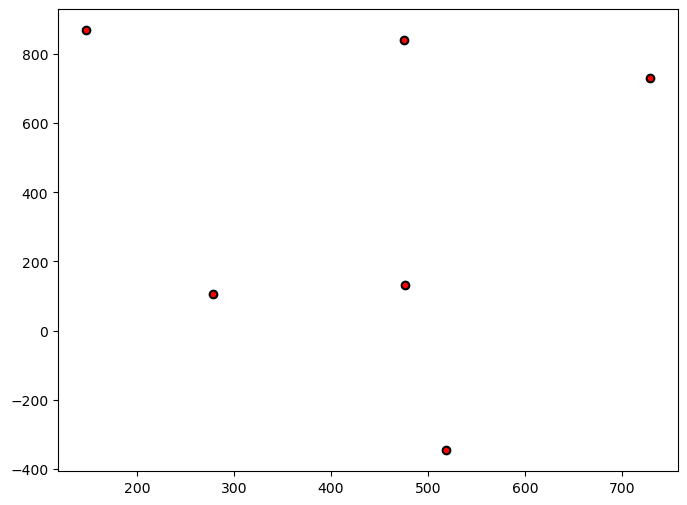

In [28]:
"""The image is displayed comparing the original pixels with the pixels projected with the calibrated matrix"""
fig = plt.figure(figsize=(8,6))
plt.plot(U[0][:nPuntos_mitad], U[1][:nPuntos_mitad], marker='o', ls='', color='k');
plt.plot(U[0][nPuntos_mitad:], U[1][nPuntos_mitad:], marker='o', ls='', color='k');
plt.plot(Ur_est[0], Ur_est[1], marker='.', ls='', color='r');

# Calibration example using OpenCV functionality
OpenCV uses the calibration method of [Zhang](http://ieeexplore.ieee.org/document/888718) which starts from several images of coplanar world points. This way the calibration pattern is much easier to build, since a pattern can simply be printed with a printer.

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image, filename, kernel_size=5, show=True):
    """
    1) Convert to gray
    2) Median blur
    3) Otsu threshold to binary
    4) Find external contours and mask them in
    Returns a cleaned binary image.
    """
    # 1) gray
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2) median blur
    median = cv2.medianBlur(gray, kernel_size)

    # 3) otsu threshold
    _, binary = cv2.threshold(
        median, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 4) find + fill external contours
    contours, _ = cv2.findContours(
        binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, contours, -1, color=255, thickness=cv2.FILLED)
    cleaned = cv2.bitwise_and(binary, mask)

    # show inline
    if show:
        plt.figure(figsize=(5,5))
        plt.imshow(cleaned, cmap='gray')
        plt.title(f"Preprocessed / Cleaned {filename}")
        plt.axis('off')
        plt.show()

    return cleaned


In [30]:
""""Extraction of pairs of world points and their corresponding projected points in pixels"""
images = glob.glob('calibration/*.bmp')
print(f"Found {len(images)} images:")
print(images)


pattern_size = (4,4) 

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[1], 0:pattern_size[0]].T.reshape(-1, 2)

# 3) Storage for all images
objpoints = []   # 3D points in real world space
imgpoints = []   # 2D points in image plane

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    preprocesssed_image = preprocess_image(img, fname, 5, show=False)
    
    # 1) detect on the cleaned mask:
    ret, corners = cv2.findChessboardCorners(
        preprocesssed_image,
        pattern_size,
        flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE
    )

    if not ret:
        print(f" ⚠️ Corners not found in {fname}, skipping.")
        continue
    else:
        print(f" ✔️ Found corners in {fname}")

    # 2) draw onto a *color* copy of your cleaned mask, so you can see the colored circles
    vis = cv2.cvtColor(preprocesssed_image, cv2.COLOR_GRAY2BGR)
    cv2.drawChessboardCorners(vis, pattern_size, corners, ret)
    cv2.imshow('cleaned + corners', vis)
    cv2.waitKey(500)

    # 6) Refine to subpixel accuracy (optional but recommended)
    gray_orig = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    criteria = (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 30, 0.001)
    corners2 = cv2.cornerSubPix(gray_orig, corners, (11, 11), (-1, -1), criteria)

    # 7) Append object points and image points
    objpoints.append(objp)
    imgpoints.append(corners2)

print(f"✔️  Collected {len(objpoints)} valid views.")


cv2.destroyAllWindows()

Found 11 images:
['calibration\\000016.bmp', 'calibration\\000020.bmp', 'calibration\\000021.bmp', 'calibration\\000023.bmp', 'calibration\\000026.bmp', 'calibration\\000027.bmp', 'calibration\\000030.bmp', 'calibration\\000034.bmp', 'calibration\\000037.bmp', 'calibration\\000038.bmp', 'calibration\\000042.bmp']
 ✔️ Found corners in calibration\000016.bmp
 ⚠️ Corners not found in calibration\000020.bmp, skipping.
 ⚠️ Corners not found in calibration\000021.bmp, skipping.
 ✔️ Found corners in calibration\000023.bmp
 ✔️ Found corners in calibration\000026.bmp
 ✔️ Found corners in calibration\000027.bmp
 ✔️ Found corners in calibration\000030.bmp
 ✔️ Found corners in calibration\000034.bmp
 ✔️ Found corners in calibration\000037.bmp
 ✔️ Found corners in calibration\000038.bmp
 ✔️ Found corners in calibration\000042.bmp
✔️  Collected 9 valid views.


# Calibrate Camera

In [31]:
# 2) Camera calibration
# we can use the size of the last image for all
h, w = img.shape[:2]
img_size = (w, h)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, img_size, None, None
)

print("Calibration RMS error:", ret)
print("Camera matrix (K):\n", mtx)
print("Distortion coeffs:", dist.ravel())

# 3) For each view, get R, T and build the 3×4 [R|T] and P = K [R|T]
for i, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
    R, _ = cv2.Rodrigues(rvec)
    T = tvec.reshape(3,1)
    RT = np.hstack((R, T))    # shape = (3,4)
    P  = mtx.dot(RT)          # 3×4 projection matrix
    print(f"\nView {i}:")
    print(" rvec:\n", rvec.ravel())
    print(" tvec:\n", tvec.ravel())
    print(" Projection P = K [R|T]:\n", P)

Calibration RMS error: 0.4172638979226078
Camera matrix (K):
 [[678.9865352    0.         292.39035285]
 [  0.         677.56960114 243.77235081]
 [  0.           0.           1.        ]]
Distortion coeffs: [ 1.93440629e-01 -1.01850513e+00  1.71665361e-03 -1.88241026e-02
  2.52062440e+00]

View 0:
 rvec:
 [ 0.01188573  0.05982077 -0.01233141]
 tvec:
 [-2.97396358 -1.34015988 11.52533813]
 Projection P = K [R|T]:
 [[ 6.60219283e+02  1.19739845e+01  3.32388261e+02  1.35061646e+03]
 [-2.27002936e+01  6.80275915e+02  2.35021062e+02  1.90150717e+03]
 [-5.98554342e-02  1.15093406e-02  9.98140703e-01  1.15253381e+01]]

View 1:
 rvec:
 [ 0.05158193 -0.00804333  1.50117589]
 tvec:
 [ 0.85643505 -1.45100746  8.96660424]
 Projection P = K [R|T]:
 [[ 5.82719040e+01 -6.68531545e+02  3.10136732e+02  3.20325644e+03]
 [ 6.84540249e+02  5.36757362e+01  2.16908015e+02  1.20265165e+03]
 [ 3.73053201e-02  2.92751030e-02  9.98875008e-01  8.96660424e+00]]

View 2:
 rvec:
 [-0.30796119  0.68498863  0.814062

# Find Homography

In [32]:
import cv2
import numpy as np

# — assume you already have:
#    objpoints : list of (N×3) arrays, but only X,Y matter
#    imgpoints : list of (N×1×2) arrays of corresponding (u,v)
#    mtx       : 3×3 camera matrix from calibrateCamera()
#    rvecs, tvecs : per-view extrinsics from calibrateCamera()

homographies_direct = []   # via point–point DLT (RANSAC)
homographies_plane  = []   # via K [r1 r2 t]

for i, (objp, corners, rvec, tvec) in enumerate(
        zip(objpoints, imgpoints, rvecs, tvecs)):

    # 1) Direct DLT from your detected corners (in case you just
    #    want a purely image-to-world fit, robustified by RANSAC)
    world_pts = objp[:, :2]                   # shape = (N,2)
    image_pts = corners.reshape(-1, 2)        # shape = (N,2)
    H_dlt, mask = cv2.findHomography(
        world_pts, image_pts,
        cv2.RANSAC,     # or 0 if you trust all correspondences
        5.0             # reprojection threshold in pixels
    )
    homographies_direct.append(H_dlt / H_dlt[2,2])
    print(f"View {i} – homography (DLT+RANSAC):\n", H_dlt)

    # 2) Recompute H using your known intrinsics+extrinsics:
    #    for a plane Z=0, the projection is H = K [r1 r2 t].
    R, _ = cv2.Rodrigues(rvec)    # turn the Rodrigues vector into a 3×3
    T = tvec.reshape(3,1)
    H_plane = mtx @ np.hstack((R[:, :2], T))
    H_plane /= H_plane[2,2]       # normalize scale to make h33 = 1
    homographies_plane.append(H_plane)
    print(f"View {i} – homography (K[R|t]):\n", H_plane)

View 0 – homography (DLT+RANSAC):
 [[ 6.06997154e+01  8.24025201e-01  1.13087243e+02]
 [-2.11917122e-01  5.99962507e+01  1.63323311e+02]
 [ 1.99210914e-03  1.94227611e-05  1.00000000e+00]]
View 0 – homography (K[R|t]):
 [[ 5.72841573e+01  1.03892696e+00  1.17186710e+02]
 [-1.96959892e+00  5.90243781e+01  1.64984936e+02]
 [-5.19337772e-03  9.98611973e-04  1.00000000e+00]]
View 1 – homography (DLT+RANSAC):
 [[ 6.30851113e+00 -7.64723524e+01  3.56928946e+02]
 [ 7.59588676e+01  4.27219904e+00  1.34489700e+02]
 [ 3.42985878e-03 -3.50635590e-03  1.00000000e+00]]
View 1 – homography (K[R|t]):
 [[ 6.49877060e+00 -7.45579404e+01  3.57242983e+02]
 [ 7.63433101e+01  5.98618326e+00  1.34125653e+02]
 [ 4.16047359e-03  3.26490411e-03  1.00000000e+00]]
View 2 – homography (DLT+RANSAC):
 [[ 1.34409738e+01 -4.87570631e+01  2.95323770e+02]
 [ 2.08574824e+01  4.09123376e+01  9.54625937e+01]
 [-6.07040070e-02 -3.42450331e-03  1.00000000e+00]]
View 2 – homography (K[R|t]):
 [[ 1.28402820e+01 -4.76166268e+0

# Test on bean picture

In [42]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew

def pre_process_and_extract_features(image):
       
    kernel_size = 5
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    median_img = cv2.medianBlur(gray_img, kernel_size)
    if len(median_img.shape) == 3:
        median_img = cv2.cvtColor(median_img, cv2.COLOR_BGR2GRAY)
    otsu_threshold, binary_img = cv2.threshold(median_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours, median_img

def preprocess_image_bean(image, filename="Some_file", kernel_size=5, show=True):
    """
    1) Convert to gray
    2) Median blur
    3) Otsu threshold to binary
    4) Find external contours and mask them in
    Returns a cleaned binary image.
    """
    # 1) gray
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2) median blur
    median = cv2.medianBlur(gray, kernel_size)

    # 3) otsu threshold
    _, binary = cv2.threshold(
        median, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 4) find + fill external contours
    contours, _ = cv2.findContours(
        binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, contours, -1, color=255, thickness=cv2.FILLED)
    cleaned = cv2.bitwise_and(binary, mask)

    # show inline
    if show:
        plt.figure(figsize=(5,5))
        plt.imshow(cleaned, cmap='gray')
        plt.title(f"Preprocessed / Cleaned {filename}")
        plt.axis('off')
        plt.show()

    return cleaned, contours

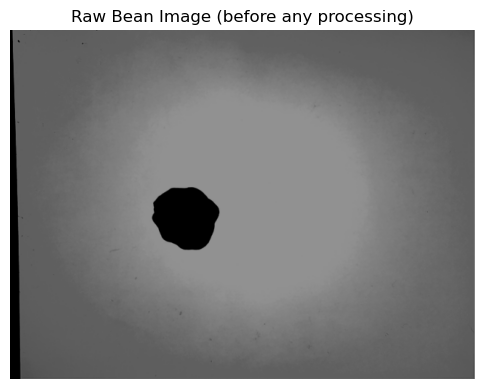

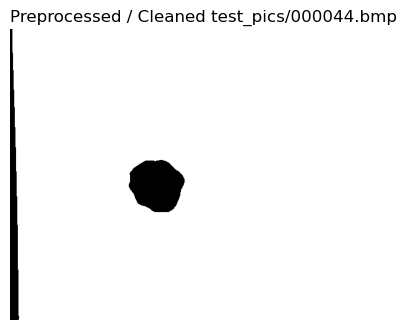

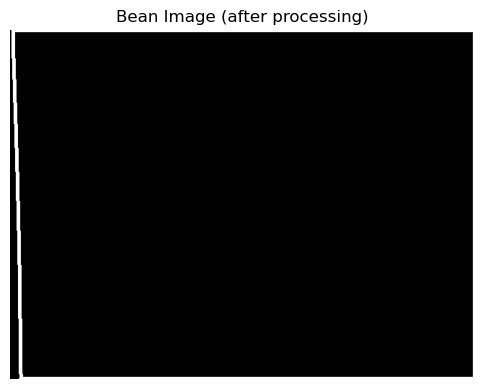

NameError: name 'co' is not defined

In [ ]:
bean_file_name = 'test_pics/000044.bmp'
bean_img = cv2.imread(bean_file_name)

if img is None:
    raise FileNotFoundError(f"Could not load {bean_img}")


# 2) Show the raw image so you can verify you’ve got the right one
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(bean_img, cv2.COLOR_BGR2RGB))
plt.title("Raw Bean Image (before any processing)")
plt.axis('off')
plt.show()


# --- 3) Detect contours & features, grab centroids ---
#contours, median_img = pre_process_and_extract_features(bean_img)
cleaned_img_bean,contours = preprocess_image_bean(bean_img, bean_file_name, kernel_size=5, show=True)

# Draw the contour on a copy of the image
vis = cleaned_img_bean.copy()
contoured_img = np.zeros_like(vis)
cv2.drawContours(contoured_img, contours, -1, (255), 4)


plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(contoured_img, cv2.COLOR_BGR2RGB))
plt.title("Bean Image (after processing)")
plt.axis('off')
plt.show()

#cv2.drawContours(vis, [contours], -1, (0, 255, 0), 3)

if not contours:
    raise RuntimeError("No objects found in the image!")

# --- 4) Find the largest object (bean) ---
areas = [cv2.contourArea(c) for c in contours]
idx = int(np.argmax(areas))
bean_contour = contours[idx]

# 5) Draw that contour
vis = bean_img.copy()
cv2.drawContours(vis, [bean_contour], -1, (0,255,0), 3)

bean_feat = max(co, key=lambda f: f["area"])
(u, v) = bean_feat["centroid"]
u, v = float(u), float(v)   # ensure numeric
print(f"Bean detected at pixel (u={u:.1f}, v={v:.1f})")

# --- 5) Transform that image point into world (X,Y) ---
H_inv = np.linalg.inv(H_plane)
p_img = np.array([u, v, 1.0])
w     = H_inv.dot(p_img)
w    /= w[2]                # normalize so [x, y, 1]
X, Y  = w[0], w[1]

print(f"Bean pixel coords:    (u={u}, v={v})")
print(f"Bean world coords:    (X={X:.2f}, Y={Y:.2f})")

# ── 5) Visualize: draw on the bean_img ───────────────────────────────
vis = bean_img.copy()

# cast to int for drawing
u_i, v_i = int(round(u)), int(round(v))

cv2.circle(vis, (u_i, v_i), 8, (0, 0, 255), -1)
cv2.putText(vis,
            f"W=({X:.1f},{Y:.1f})",
            (u_i + 10, v_i - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 255),
            2)

cv2.imshow("Bean Detection & Localization", vis)
cv2.waitKey(0)
cv2.destroyAllWindows()

OTHER CODE

In [ ]:
"""Camera calibration"""
# Do camera calibration given object points and image points
img_size = (img.shape[1], img.shape[0])
print('img_size:', img_size)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
print('ret:', ret, 'mtx:', mtx, 'dist:', dist, 'rvecs:', rvecs, 'tvecs:', tvecs)

#S = cv2.calibrationMatrixValues(mtx, img_size, 6.17, 4.55);
#print(S)
#fovx	Output field of view in degrees along the horizontal sensor axis.
#fovy	Output field of view in degrees along the vertical sensor axis.
#focalLength	Focal length of the lens in mm.
#principalPoint	Principal point in mm.
#aspectRatio	fy/fx

# Show P of the first calibration image
K = mtx
R = cv2.Rodrigues(rvecs[0])[0]
T = tvecs[0]
RT = np.concatenate((R,T),axis=1)
Pest0 = np.dot(K, RT)

#print('Matriz de intrínsecos:')
#print(ca.ndtotext(K))

#print('Matriz de rotación:')
#print(ca.ndtotext(R))

#print('Vector de traslación:')
#print(ca.ndtotext(T)

print('Projection matrix for image0:')
print(ca.ndtotext(Pest0))

img_size: (640, 480)
ret: 0.4172638979226078 mtx: [[678.9865352    0.         292.39035285]
 [  0.         677.56960114 243.77235081]
 [  0.           0.           1.        ]] dist: [[ 1.93440629e-01 -1.01850513e+00  1.71665361e-03 -1.88241026e-02
   2.52062440e+00]] rvecs: (array([[ 0.01188573],
       [ 0.05982077],
       [-0.01233141]]), array([[ 0.05158193],
       [-0.00804333],
       [ 1.50117589]]), array([[-0.30796119],
       [ 0.68498863],
       [ 0.81406299]]), array([[0.06589317],
       [0.0696223 ],
       [1.52647837]]), array([[0.42792936],
       [0.40178795],
       [1.45228954]]), array([[-0.1524244 ],
       [ 0.45109097],
       [ 0.80601957]]), array([[0.05068187],
       [0.01730221],
       [1.53878581]]), array([[4.63760936e-02],
       [9.77886981e-04],
       [1.52207332e+00]]), array([[0.02639296],
       [0.36787059],
       [0.02021359]])) tvecs: (array([[-2.97396358],
       [-1.34015988],
       [11.52533813]]), array([[ 0.85643505],
       [-1.45100

In [ ]:
"""Save the camera calibration result for later use (we won't worry about rvecs / tvecs)"""
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

In [ ]:
"""Show error in the first image with OpenCV funcionality"""
U = cv2.projectPoints(objpoints[0], rvecs[0], tvecs[0], mtx, dist)
error = np.asarray(U[0][:,0]-imgpoints[0][:,0,:])
error = np.linalg.norm(error)/len(error)
print("Retroprojection error with OpcenCV for first image:", error)

# Show error in the first image with Python funcionality
mpoints = np.transpose(objpoints[0])
n_points = len(mpoints[0])
lista_ones = np.ones((1,n_points)).tolist()
mpoints =  np.append(mpoints, lista_ones, axis=0)

U = np.dot(Pest0, mpoints)
U = [ [U[0] / U[2]], [U[1] / U[2]] ]
U = np.reshape(np.array(U, dtype="float32").transpose(), (n_points,1,2))

imgpoints_nd = cv2.undistortPoints(imgpoints[0], mtx, dist, None, mtx)
error1 = U-imgpoints_nd
error1 = np.linalg.norm(error1)/len(error1)
#error1 = cv2.norm(U, imgpoints_nd, cv2.NORM_L2)/len(imgpoints_nd)
print("Retroprojection error for first image:",error1)

Retroprojection error with OpcenCV for first image: 0.06834160536527634
Retroprojection error for first image: 0.06697417795658112


In [ ]:
homographies = []
for rvec, tvec in zip(rvecs, tvecs):
    R, _ = cv2.Rodrigues(rvec)
    # build the 3×3 [r1 r2 t] matrix for the plane Z=0
    Rt = np.hstack((R[:, :2], tvec.reshape(3,1)))
    H = mtx @ Rt
    homographies.append(H / H[2,2])


## - Print homography --------------------
print(H)



[[ 5.28370681e+02 -1.53832786e+00  8.10331568e+02]
 [-7.09482001e+01  6.84384077e+02  2.16152243e+03]
 [-3.59298738e-01  2.94728083e-02  1.12400752e+01]]
